In [29]:
import sionna
from sionna.rt import load_scene, Scene
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy import ndimage as ndi

In [ ]:
def number_of_discretization_points(x0: float, y0: float, xN: float, yN: float, h: float) -> tuple[int, int]:
    """Compute the number of discretization points in a rectangular area."""

    nx = int(np.floor((xN - x0)/h)) + 1
    ny = int(np.floor((yN - y0)/h)) + 1

    return nx, ny

def height_map(
        scene: "Scene", 
        step_size_power: int = 10, 
        step_size_exponent: int = 0, 
        min_height: float = 10.0
        ) -> tuple[np.ndarray, tuple[float, float, float]]:
    """Compute a 2D height map of the scene."""

    h = step_size_power ** step_size_exponent
    scene = load_scene(scene, merge_shapes=False) if isinstance(scene, str) else scene
    scene_bbox = scene.mi_scene.bbox()
    x0, y0 = float(scene_bbox.min.x), float(scene_bbox.min.y)
    xN, yN = float(scene_bbox.max.x), float(scene_bbox.max.y)

    nx, ny = number_of_discretization_points(x0, y0, xN, yN, h)
    Z = np.full((ny, nx), np.nan, dtype=float)

    bboxes = []
    for obj in tqdm(scene.objects.values(), desc="Validating scene objects for height map"):
        if getattr(obj, "mi_mesh", None) and obj.name not in ['ground', 'Terrain', 'Plane', 'floor']:
            if obj.mi_mesh.bbox().extents()[2] >= min_height:
                bboxes.append(obj.mi_mesh.bbox())

    for bb in tqdm(bboxes, desc="Computing height map for each scene object"):
        col_idx_min = int(np.ceil((float(bb.min.x) - x0)/h))
        col_idx_max = int(np.floor((float(bb.max.x) - x0)/h))
        row_idx_min = int(np.ceil((float(bb.min.y) - y0)/h))
        row_idx_max = int(np.floor((float(bb.max.y) - y0)/h))
        col_idx_min = max(col_idx_min, 0)
        row_idx_min = max(row_idx_min, 0)
        col_idx_max = min(col_idx_max, nx-1)
        row_idx_max = min(row_idx_max, ny-1)
        if col_idx_min > col_idx_max or row_idx_min > row_idx_max: 
            continue

        block = Z[row_idx_min:row_idx_max+1, col_idx_min:col_idx_max+1]
        np.fmax(block, float(bb.max.z), out=block)

    return Z, (x0, y0, xN, yN, h)

def plot_height_map(
        Z: np.ndarray, 
        x0: float, y0: float, xN: float, yN: float, h: float, 
        cmap: str = 'viridis',
        txs: dict[str, tuple[float, float]] = {}
        ) -> None:
    """Plot a 2D height map."""
    
    extent = [x0 - h/2, xN + h/2, y0 - h/2, yN + h/2]

    plt.figure(figsize=(8,6))
    im = plt.imshow(Z, extent=extent, origin='lower', cmap=cmap)
    plt.colorbar(im, label='Height (m)')
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.title('Height Map')

    for label, (x, y) in txs.items():
        plt.scatter(x, y, label=label)

    plt.legend()
    plt.show()

In [30]:
def prep_nearest_map(Z: np.ndarray):
    """Precompute nearest valid (row,col) indices for every pixel."""
    valid = ~np.isnan(Z)
    nearest_idx = ndi.distance_transform_edt(
        ~valid, return_distances=False, return_indices=True
    )
    return nearest_idx 

def world_to_index(x: float, y: float, x0: float, y0: float, xN: float, yN: float, h: float) -> tuple[int, int]:
    """Convert world coordinates to height map indices."""
    nx, ny = number_of_discretization_points(x0, y0, xN, yN, h)

    i = int(np.clip(np.round((x - x0)/h), 0, nx-1))  # col (x)
    j = int(np.clip(np.round((y - y0)/h), 0, ny-1))  # row (y)
    return i, j

def index_to_world(i: int, j: int, x0: float, y0: float, xN: float, yN: float, h: float) -> tuple[float, float]:
    """Convert height map indices to world coordinates."""
    x = x0 + i * h
    y = y0 + j * h
    return x, y

def snap_to_nearest_valid_height(
        x: float, y: float, 
        Z: np.ndarray, 
        nearest_idx: np.ndarray, 
        x0: float, y0: float, xN: float, yN: float, h: float
        ) -> tuple[float, float, float]:
    """Snap world coordinates to nearest valid height map point."""
    i, j = world_to_index(x, y, x0, y0, xN, yN, h)

    j_valid, i_valid = nearest_idx[:, j, i]
    z_snapped = Z[j_valid, i_valid]

    x_snapped, y_snapped = index_to_world(i_valid, j_valid, x0, y0, xN, yN, h)
    
    return x_snapped, y_snapped, z_snapped

In [3]:
scene = load_scene(sionna.rt.scene.etoile, merge_shapes=False)

In [26]:
Z, bounds = height_map(scene, step_size_power=10, step_size_exponent=-1, min_height=10.0)

Computing height map for each scene object: 100%|██████████| 242/242 [00:00<00:00, 3157.79it/s]


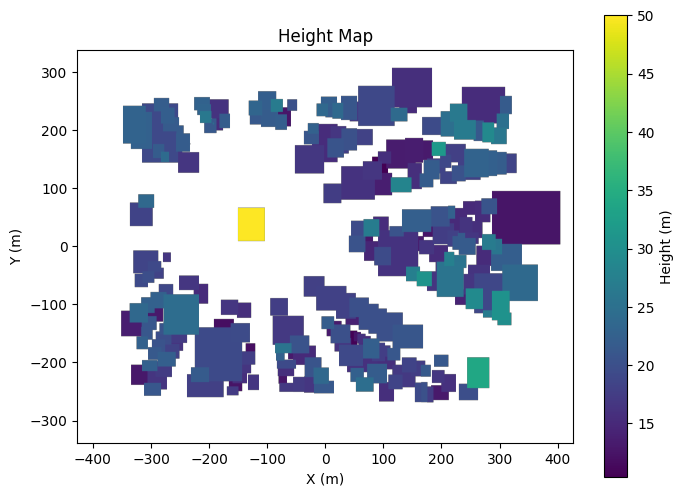

In [33]:
plot_height_map(Z, *bounds)

In [31]:
nearest_idx = prep_nearest_map(Z)

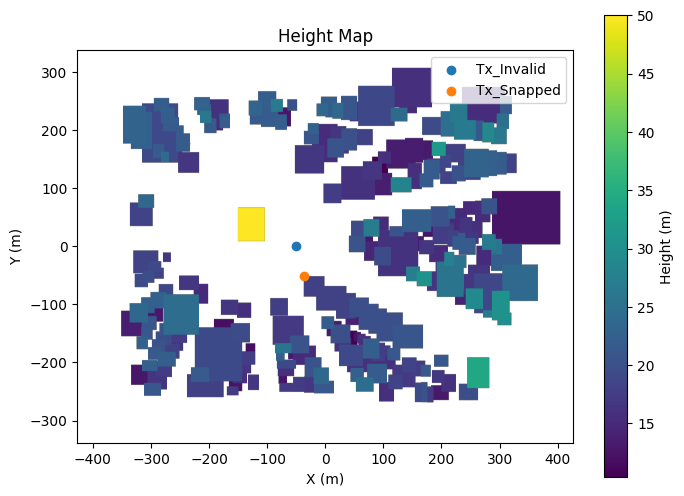

In [ ]:
Tx_Invalid = (-50.123342112, 0.4221974324)      # Some invalid tx location
x_snapped, y_snapped, z_snapped = snap_to_nearest_valid_height(
    *Tx_Invalid, Z, nearest_idx, *bounds
)

txs = {
    "Tx_Invalid": Tx_Invalid,
    "Tx_Snapped": (x_snapped, y_snapped)
}

plot_height_map(Z, *bounds, txs=txs)

TODO: Pre-compute nearest neighbor map for all scenes and store for fast lookup.